In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

np.seterr(divide="ignore")
import seaborn as sns
from bisect import bisect
from tqdm import tqdm
from functools import partial
from scipy.stats import ttest_ind
from scipy.optimize import curve_fit
import statsmodels.formula.api as smf

sns.set_style("darkgrid")
import typing
from typing import Optional, List
import os


def listdir(p: str):
    return [os.path.join(p, f) for f in os.listdir(p)]

# AllReduce Modeling (H100 Data)

We first use `all_gather` data as a measure of the inter-node and intra-node bandwidths.

In [8]:
gpus_per_node = 8

## Inter-Node Bandwidth

In [45]:
internode_files = [
    x
    for x in os.listdir(
        "/Users/emma/Documents/dodrio-data-0827/collective-benchmarking-data-H100/torchtitan-16-sanketpurandare-m77vsbd/all_gather/all_gather_16"
    )
    if x.count("_") == 4
]

In [505]:
def compute_internode_bw(all_gather_path: str):
    df = pd.read_csv(all_gather_path, header=None)
    df.columns = ["size", "time"]

    bw = (gpus_per_node * df["size"]) / df["time"]
    df["bandwidth"] = bw

    return df.groupby("size").median().reset_index()

In [506]:
inter_bw_df = (
    pd.concat(
        [
            compute_internode_bw(
                f"/Users/emma/Documents/dodrio-data-0827/collective-benchmarking-data-H100/torchtitan-16-sanketpurandare-m77vsbd/all_gather/all_gather_16/{p}"
            )
            for p in internode_files
        ]
    )
    .groupby("size")
    .median()
    .reset_index()
)

Text(0.5, 1.0, 'Inter-Node Bandwidth')

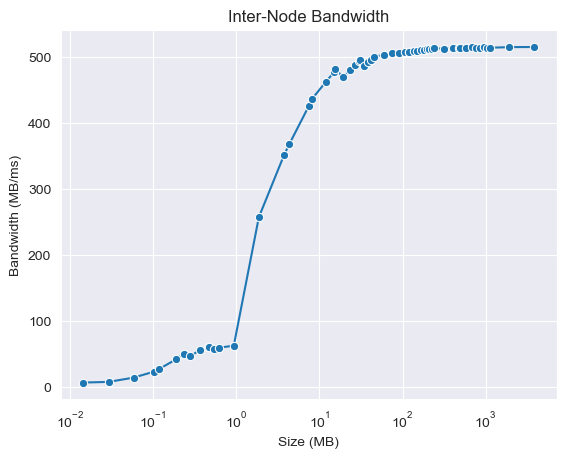

In [507]:
sns.lineplot(data=inter_bw_df, x="size", y="bandwidth", marker="o")
plt.xscale("log")
plt.xlabel("Size (MB)")
plt.ylabel("Bandwidth (MB/ms)")
plt.title("Inter-Node Bandwidth")

## Intra-Node Bandwidth

In [508]:
intranode_files = [
    x
    for x in os.listdir(
        "/Users/emma/Documents/dodrio-data-0827/collective-benchmarking-data-H100/torchtitan-8-sanketpurandare-k731q2cw/all_gather/all_gather_8"
    )
    if x.count("_") == 3
]

In [509]:
def compute_intranode_bw(all_gather_path: str):
    df = pd.read_csv(all_gather_path, header=None)
    df.columns = ["size", "time"]

    bw = ((gpus_per_node - 1) * df["size"]) / df["time"]
    df["bandwidth"] = bw

    return df.groupby("size").median().reset_index()

In [510]:
intra_bw_df = (
    pd.concat(
        [
            compute_intranode_bw(
                f"/Users/emma/Documents/dodrio-data-0827/collective-benchmarking-data-H100/torchtitan-8-sanketpurandare-k731q2cw/all_gather/all_gather_8/{p}"
            )
            for p in intranode_files
        ]
    )
    .groupby("size")
    .median()
    .reset_index()
)

Text(0.5, 1.0, 'Intra-Node Bandwidth')

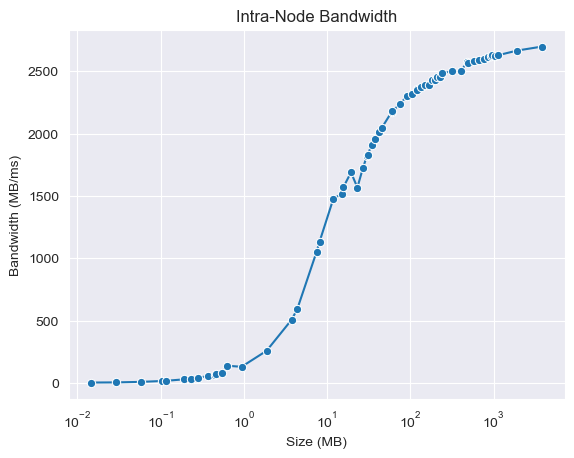

In [511]:
sns.lineplot(data=intra_bw_df, x="size", y="bandwidth", marker="o")
plt.xscale("log")
plt.xlabel("Size (MB)")
plt.ylabel("Bandwidth (MB/ms)")
plt.title("Intra-Node Bandwidth")

## Fitting Bandwidth Sigmoid Curves

In [512]:
def sigmoid(x, L, x0, k):
    y = L / (1 + np.exp(-k * (x - x0)))
    return y


def log_sigmoid(x, L, x0, k):
    return sigmoid(np.log(x), L, x0, k)


def fit_sigmoid(data: pd.DataFrame):
    guess = [
        max(data["bandwidth"]),
        np.median(np.log(data["size"])),
        1,
    ]  # this is an mandatory initial guess
    params, _ = curve_fit(
        sigmoid,
        np.log(data["size"]),
        data["bandwidth"],
        guess,
        method="dogbox",
        bounds=(-np.inf, [np.inf, np.inf, np.inf]),
    )

    return params

In [513]:
interbw_params, intrabw_params = fit_sigmoid(inter_bw_df), fit_sigmoid(intra_bw_df)

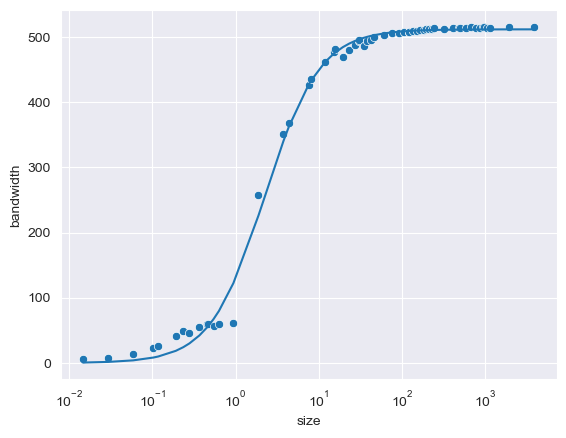

In [514]:
sns.scatterplot(
    data=inter_bw_df,
    x="size",
    y="bandwidth",
)
sns.lineplot(
    x=inter_bw_df["size"],
    y=[log_sigmoid(size, *interbw_params) for size in inter_bw_df["size"]],
)
plt.xscale("log")

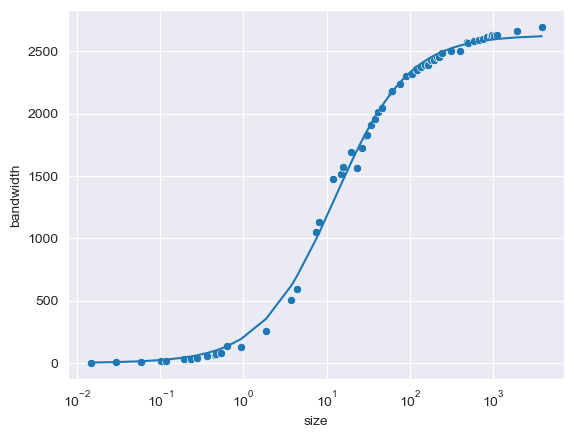

In [515]:
sns.scatterplot(
    data=intra_bw_df,
    x="size",
    y="bandwidth",
)
sns.lineplot(
    x=intra_bw_df["size"],
    y=[log_sigmoid(size, *intrabw_params) for size in intra_bw_df["size"]],
)
plt.xscale("log")

In [516]:
def inter_bw(x):
    return log_sigmoid(x, *interbw_params)


def intra_bw(x):
    return log_sigmoid(x, *intrabw_params)

We use the minimum bandwidth recorded for the latency.

In [517]:
def get_latency(df: pd.DataFrame):
    return df.sort_values("size").iloc[0]["time"]

In [518]:
internode_latency, intranode_latency = get_latency(inter_bw_df), get_latency(
    intra_bw_df
)

## AllReduce Benchmarking Data

In [341]:
def get_allreduce_files(path: str):
    allreduce_dir = listdir(os.path.join(path, "all_reduce"))
    assert len(allreduce_dir) == 1
    f = listdir(allreduce_dir[0])

    # only use 1D data
    f_1d = [x for x in f if os.path.basename(x).count("_") == 3]
    return sorted(f_1d)

In [342]:
# TODO: replace with path to mast data
data_dir = "/Users/emma/Documents/dodrio-data-0827/collective-benchmarking-data-H100"

In [343]:
all_reduce_data_paths = {
    int(os.path.basename(f).split("-")[1]): get_allreduce_files(f)
    for f in listdir(data_dir)
    if ".DS_Store" not in f  # Mac shenanigans
}

for k, v in all_reduce_data_paths.items():
    assert len(v) == k

In [344]:
all_reduce_data = []

for N, files in all_reduce_data_paths.items():
    worldsize_df = pd.concat([pd.read_csv(f, header=None) for f in files])
    worldsize_df.columns = ["size", "time"]
    worldsize_df = worldsize_df.groupby("size").quantile(0.75).reset_index()
    worldsize_df["N"] = N

    all_reduce_data.append(worldsize_df.set_index("size"))

all_reduce_df = pd.concat(all_reduce_data).reset_index()

In [345]:
pd.unique(all_reduce_df["N"])

array([128,  24, 160,   8, 384,  96,  64,  48,  32,  16, 320, 512, 480,
       256, 240, 192,  40])

<Axes: xlabel='size', ylabel='time'>

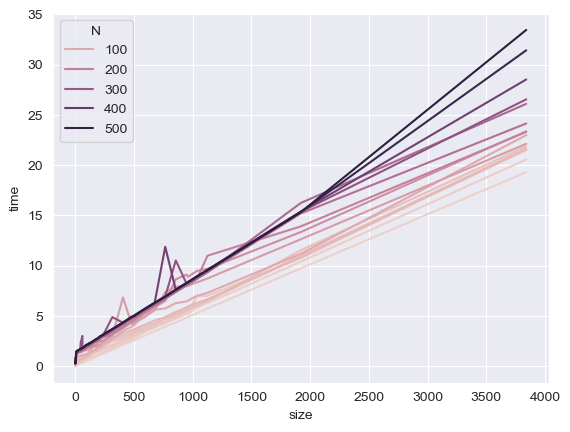

In [346]:
sns.lineplot(data=all_reduce_df, x="size", y="time", hue="N")

/var/folders/mw/_xv12nv1779bn8gplhpw9jnr0000gn/T/ipykernel_23924/828843527.py:8: RuntimeWarning: invalid value encountered in scalar divide
  y=[x / intra_bw(x) for x in np.linspace(0, 10, 100)],
/var/folders/mw/_xv12nv1779bn8gplhpw9jnr0000gn/T/ipykernel_23924/828843527.py:34: RuntimeWarning: invalid value encountered in scalar divide
  y=[x / inter_bw(x) for x in np.linspace(0, 10, 100)],


Text(0.5, 1.0, 'Inter-Node Bandwidth Curve w/ Adjustment')

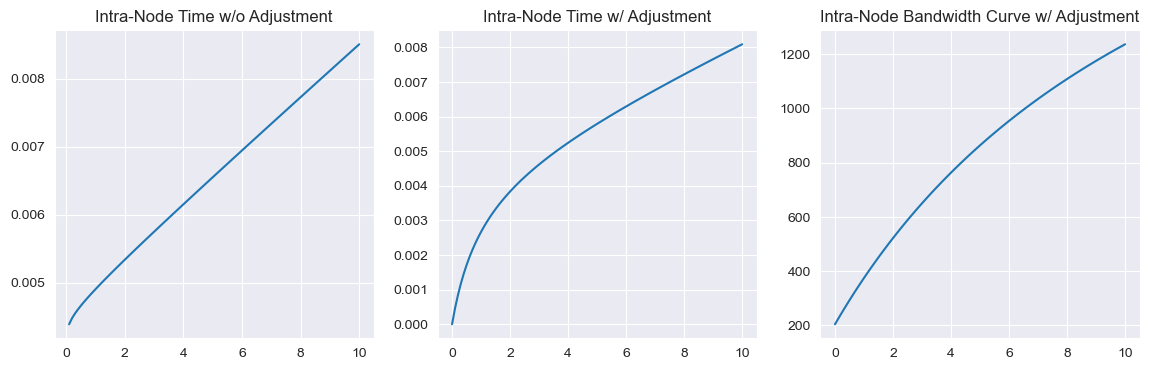

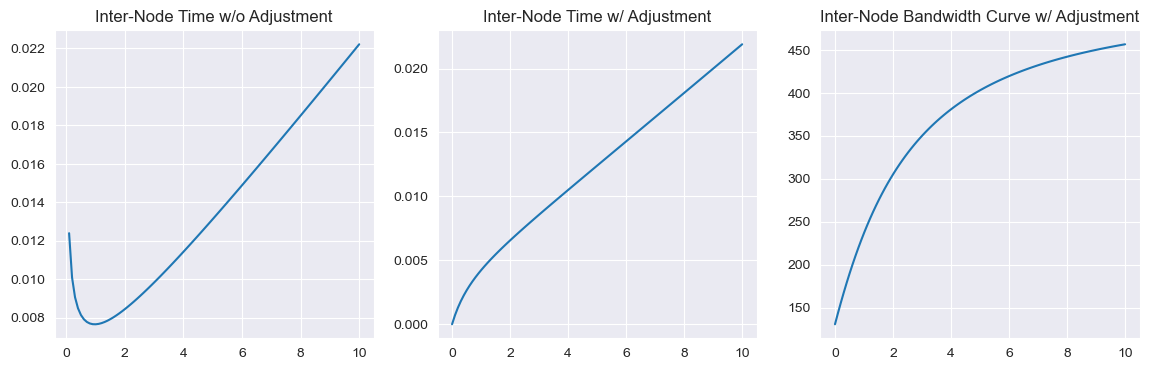

In [519]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

intra_offset = 1
inter_offset = 1

sns.lineplot(
    x=np.linspace(0, 10, 100),
    y=[x / intra_bw(x) for x in np.linspace(0, 10, 100)],
    ax=ax[0],
)
ax[0].set_title("Intra-Node Time w/o Adjustment")

sns.lineplot(
    x=np.linspace(0, 10, 100),
    y=[
        (x) / intra_bw(x + intra_offset)
        for x in np.linspace(0, 10, 100)
    ],
    ax=ax[1],
)
ax[1].set_title("Intra-Node Time w/ Adjustment")

sns.lineplot(
    x=np.linspace(0, 10, 100),
    y=[intra_bw(x + intra_offset) for x in np.linspace(0, 10, 100)],
    ax=ax[2],
)
ax[2].set_title("Intra-Node Bandwidth Curve w/ Adjustment")

fig, ax = plt.subplots(1, 3, figsize=(14, 4))

sns.lineplot(
    x=np.linspace(0, 10, 100),
    y=[x / inter_bw(x) for x in np.linspace(0, 10, 100)],
    ax=ax[0],
)
ax[0].set_title("Inter-Node Time w/o Adjustment")

sns.lineplot(
    x=np.linspace(0, 10, 100),
    y=[x / inter_bw(x + inter_offset) for x in np.linspace(0, 10, 100)],
    ax=ax[1],
)
ax[1].set_title("Inter-Node Time w/ Adjustment")

sns.lineplot(
    x=np.linspace(0, 10, 100),
    y=[inter_bw(x + inter_offset) for x in np.linspace(0, 10, 100)],
    ax=ax[2],
)
ax[2].set_title("Inter-Node Bandwidth Curve w/ Adjustment")

In [520]:
def all_reduce_model(data_size: float, N: int):
    global internode_latency, intranode_latency
    
    time_tree = (2 * data_size) / (inter_bw(data_size + 1)) if N > 1 else 0
    time_chain = (2 * data_size) / (intra_bw(data_size + 1))

    return time_tree + time_chain

<Axes: xlabel='size', ylabel='time'>

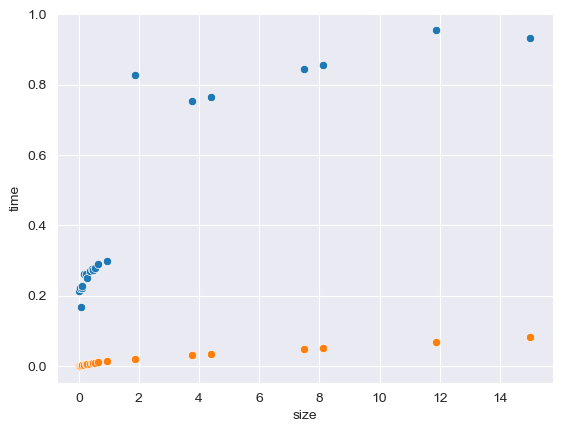

In [521]:
this_N = 96

sns.scatterplot(data=all_reduce_df[all_reduce_df.N == this_N].set_index("size").loc[:15], x="size", y="time")
sns.scatterplot(x=all_reduce_df[all_reduce_df.N == this_N].set_index("size").loc[:15].index, y=[all_reduce_model(x, this_N) for x in all_reduce_df[all_reduce_df.N == this_N].set_index("size").loc[:15].index])

In [522]:
all_reduce_df["latency"] = all_reduce_df.apply(lambda x: (np.floor(np.log2(x["N"])) + 1) * internode_latency + 7 * intranode_latency, axis=1)
all_reduce_df["model"] = all_reduce_df.apply(lambda x: all_reduce_model(x["size"], x["N"]), axis=1)

In [523]:
mod = smf.ols(formula="time ~ model + model * size + model * N + latency * size", data=all_reduce_df)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 1.200e+04
Date:                Sun, 08 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:08:46   Log-Likelihood:                -566.20
No. Observations:                1020   AIC:                             1148.
Df Residuals:                    1012   BIC:                             1188.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.9280      0.328    -15.028      0.000      -5.572      -4.285
model           57.5451      3.720     15.468      0.000      50.245      64.846
size            -0.2649      0.017    -15.223      0.000      -0.299      -0.231
model:size   -4.571e-05   3.58e-06    -12.761      0.000   -5.27e-05   -3.87e-05
N               -0.0007      0.000     -3.613      0.000      -0.001      -0.000
model:N          0.0010   6.49e-05     14.887      0.000       0.001       0.001
latency         14.1608      0.988     14.335      0.000      12.222      16.099
latency:size     0.0061      0.002      4.018      0.000       0.003       0.009
==============================================================================
Omnibus:                      715.012   Durbin-Watson:                   1.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28378.063
Skew:                           2.695   Prob(JB):                         0.00
Kurtosis:                      28.272   Cond. No.                     2.62e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**"Smart" Prediction**

As shown below, due to all_reduce times for small data sizes in the small N case being a) less frequently-appearing in the dataset and b) particularly non-linear, our statistical model struggles with predicting positive values for these datapoints.

However, we observe that our analytical cost model performs rather well at predicting these times, suggesting that the effects of straggler delay and/or the relationship between all_reduce time and size/number of nodes is not as strong for these data sizes and world sizes.

Thus, we use a "smart" prediction strategy, by which if the regression model predicts a negative value, we replace it with the analytical cost model.

In [524]:
all_reduce_df["pred"] = res.predict()

all_reduce_df["smart_predict"] = all_reduce_df.apply(lambda x: yhat if (yhat := res.predict(x).item()) > 0 else x["model"], axis=1)

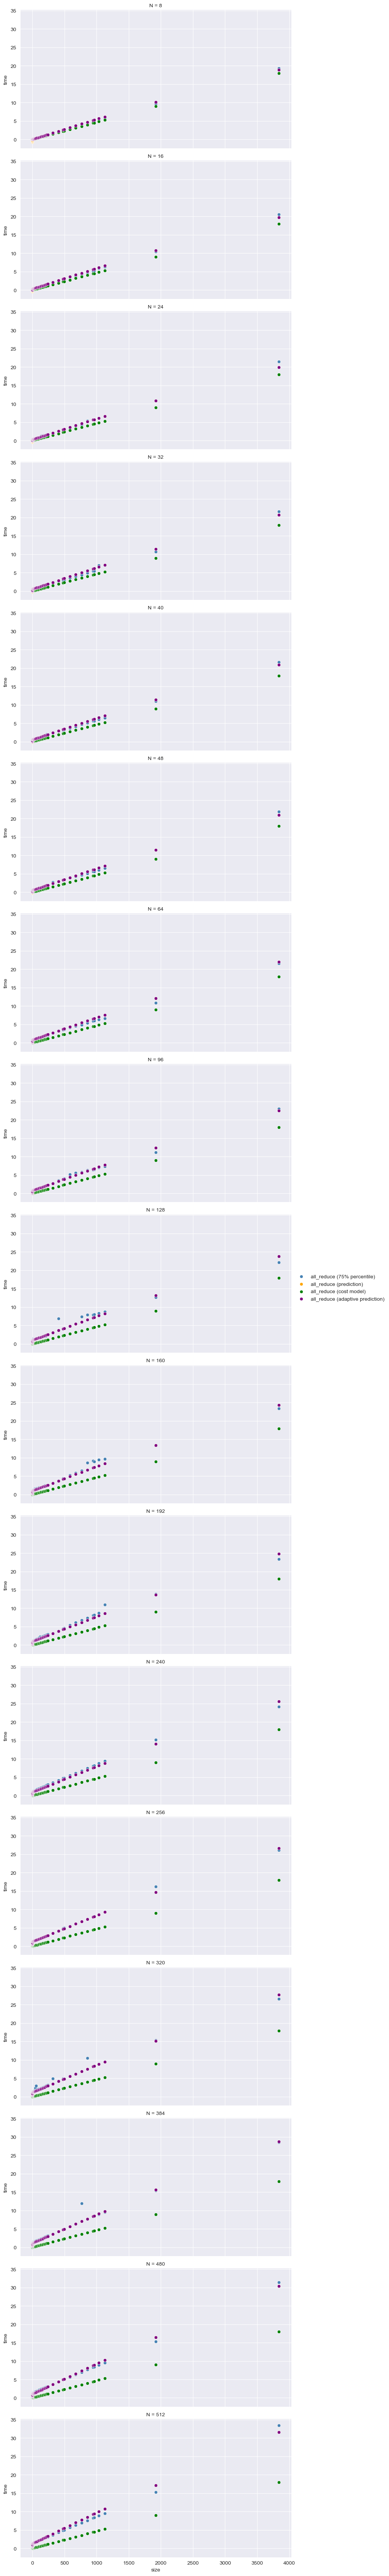

In [525]:
def plot_scatter(data, x, y, **kwargs):
    sns.scatterplot(data=data, x=x, y="time", label="all_reduce (75% percentile)", color="steelblue")
    sns.scatterplot(data=data, x=x, y="pred", label="all_reduce (prediction)", color="orange")
    sns.scatterplot(data=data, x=x, y="model", label="all_reduce (cost model)", color="green")
    sns.scatterplot(data=data, x=x, y="smart_predict", label="all_reduce (adaptive prediction)", color="purple")

g = sns.FacetGrid(data=all_reduce_df, row="N", height=4, aspect=2)
g.map_dataframe(plot_scatter, x="size", y="time")
g.add_legend()

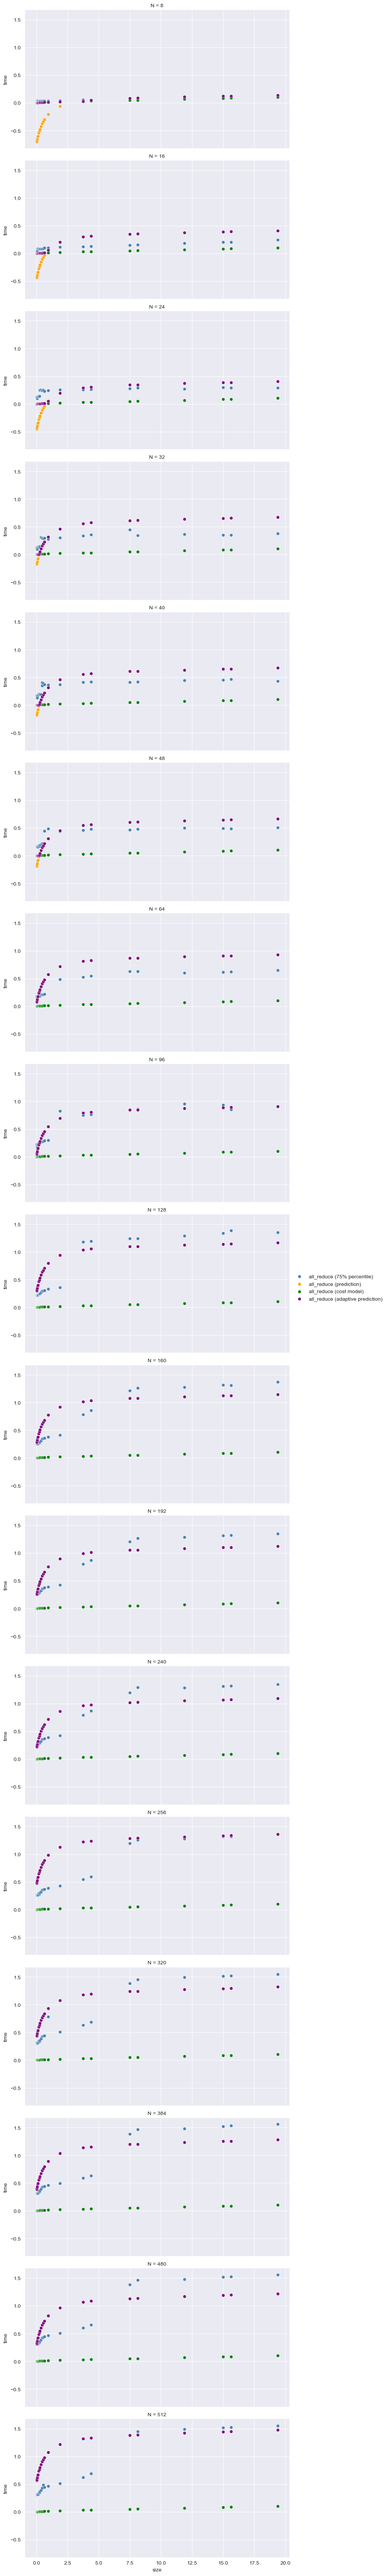

In [526]:
def plot_scatter(data, x, y, **kwargs):
    sns.scatterplot(data=data.set_index("size").loc[:20], x=x, y="time", label="all_reduce (75% percentile)", color="steelblue")
    sns.scatterplot(data=data.set_index("size").loc[:20], x=x, y="pred", label="all_reduce (prediction)", color="orange")
    sns.scatterplot(data=data.set_index("size").loc[:20], x=x, y="model", label="all_reduce (cost model)", color="green")
    sns.scatterplot(data=data.set_index("size").loc[:20], x=x, y="smart_predict", label="all_reduce (adaptive prediction)", color="purple")


g = sns.FacetGrid(data=all_reduce_df, row="N", height=4, aspect=2)
g.map_dataframe(plot_scatter, x="size", y="time")

g.add_legend()